In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import date
# from sklearn.linear_model import LinearRegression
# from sklearn import preprocessing

pd.set_option("display.max_rows", None)
plt.style.use('ggplot')

In [2]:
b = pd.read_csv("D:/實習/統一期貨/工作/統計套利/brent.csv")
b = b[['Date', 'Open', 'Price']]
b.columns = ['date', 'open_b', 'close_b']
w = pd.read_csv("D:/實習/統一期貨/工作/統計套利/wti.csv")
w = w[['Date', 'Open', 'Price']]
w.columns = ['date', 'open_w', 'close_w']


b['date'] = pd.to_datetime(b['date'])
w['date'] = pd.to_datetime(w['date'])

In [3]:
date = pd.read_csv("D:/實習/統一期貨/工作/統計套利/最後結算日.csv", encoding = 'ANSI')
date['西德州最後結算日'] = pd.to_datetime(date['西德州最後結算日'])
date['布蘭特最後結算日'] = pd.to_datetime(date['布蘭特最後結算日'])

date['西德州轉倉日'] = date['西德州最後結算日'] - datetime.timedelta(5)
date['布蘭特轉倉日'] = date['布蘭特最後結算日'] - datetime.timedelta(5)

date = date[['西德州轉倉日', '布蘭特轉倉日']]

In [4]:
data = pd.merge(w, b, on = 'date', how = 'inner')
data = data.dropna().reset_index(drop = True)
# data = data.drop([5115, 5116], axis = 0).reset_index(drop = True)

data['spread'] = data['close_w'] - data['close_b']
data['mean'] = data['spread'].rolling(60).mean()
data['std'] = data['spread'].rolling(60).std()
data['ub'] = data['mean'] + 2* data['std']
data['lb'] = data['mean'] - 2* data['std']

#波動度的叢聚效應
data['fmd'] = data['std'].rolling(7).mean()
data['smd'] = data['std'].rolling(21).mean()


data['spreadd'] = (data['open_w']-data['open_b'])
data['point'] = np.round(data['spreadd'].diff(), 4)

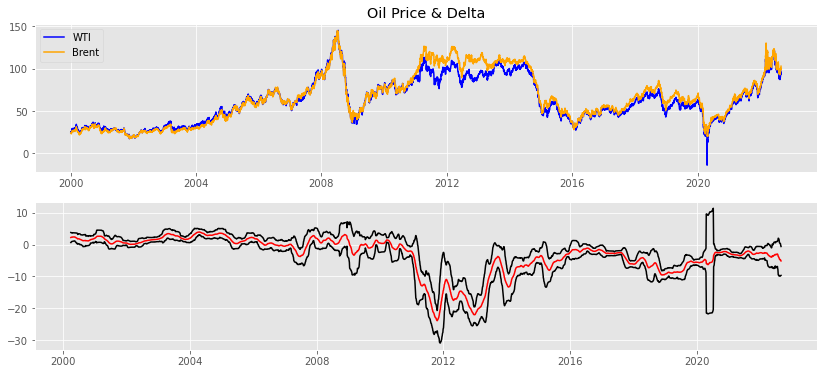

In [5]:
plt.figure(figsize = (14, 6))

plt.subplot(2, 1, 1)
plt.title("Oil Price & Delta")
plt.plot(data['date'], data['open_w'], color = 'blue')
plt.plot(data['date'], data['open_b'], color = "orange")
plt.legend(['WTI', 'Brent'])

plt.subplot(2, 1, 2)
plt.plot(data['date'], data['mean'], color = "red")
plt.plot(data['date'], data['ub'], color = "black")
plt.plot(data['date'], data['lb'], color = "black")
# plt.legend(['WTI', 'Brent'])

plt.show()

In [12]:
pos = [0]
buy_price = []

for i in range(1, len(data)):
    if pos[-1] == 0:
        if (data.loc[i, 'spread'] > data.loc[i, 'ub']) & (data.loc[i, "fmd"] < data.loc[i, 'smd']) :
            pos.append(-1)
            buy_price.append(data.loc[i+1, 'spreadd'])
        elif (data.loc[i, 'spread'] < data.loc[i, 'lb']) & (data.loc[i, "fmd"] < data.loc[i, 'smd']) :
            pos.append(1)
            buy_price.append(data.loc[i+1, 'spreadd'])
        else:
            pos.append(pos[-1])
            
    elif pos[-1] < 0:
        if data.loc[i, 'spread'] < data.loc[i, 'mean']:
            pos.append(pos[-1] + 1)
#         elif (data.loc[i, 'fmd'] > data.loc[i, 'smd']):
#             pos.append(pos[-1] + 1)
        else :
            pos.append(pos[-1])
    elif pos[-1] > 0:
        if data.loc[i, 'spread'] > data.loc[i, 'mean']:
            pos.append(pos[-1] - 1)
#         elif (data.loc[i, 'fmd'] > data.loc[i, 'smd']):
#             pos.append(pos[-1] - 1)
        else :
            pos.append(pos[-1])
            
data['pos'] = pos
data['pos'] = data['pos'].shift()
data['pos'][0] = 0

C:\Users\User\AppData\Local\Temp\ipykernel_28192\2565195298.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pos'][0] = 0


In [13]:
data['pnl'] = np.nan
fee = 100

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] != 0):
        data.loc[i, 'pnl'] = -fee
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] != 0):
        #持有部位時須轉倉
        if (data.loc[i, 'date'] in np.array(date['西德州轉倉日'])):
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        elif(data.loc[i, 'date'] in np.array(date['布蘭特轉倉日'])) :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        else :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i-1, 'pos'] * data.loc[i, 'point'])*1000 - fee
        
data['pnl'] = (200000 + data['pnl'].cumsum())
data['high'] = data['pnl'].cummax()
data['dd'] =  (data['pnl'] - data['high'])/data['high']

eh = data.drop_duplicates(["high"])

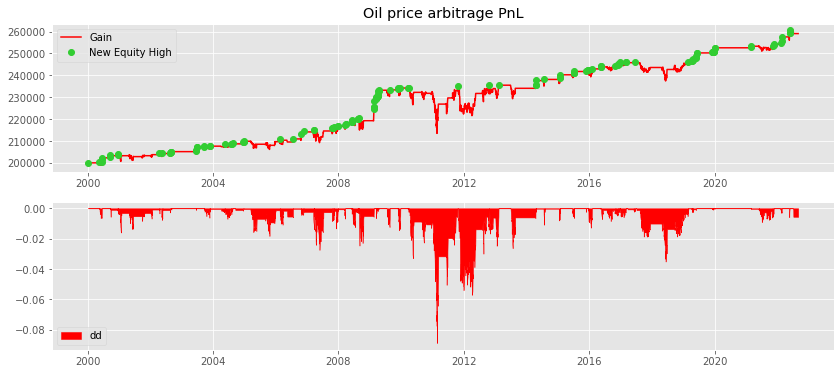

In [14]:
plt.figure(figsize = (14, 6))

plt.subplot(2, 1, 1)
plt.title("Oil price arbitrage PnL")
plt.plot(data['date'], data['pnl'], color = "red")
plt.plot(eh['date'], eh['pnl'], "o", color = "limegreen")
plt.legend(['Gain', 'New Equity High'])

plt.subplot(2, 1, 2)
plt.fill_between(data['date'], data['dd'], interpolate=False, color='red')
plt.legend(['dd'], loc = 'lower left')

plt.show()

In [79]:
mean = np.mean(data['pnl'].pct_change())*252
s = np.std(data['pnl'].pct_change())*(252**0.5)
sp = np.round(mean/s, 4)

ret = np.round((data.loc[5723, 'pnl']-200000)/200000, 4) *100
mdd = -np.round(data.loc[:, 'dd'].min(), 4) *100
rm = np.round(ret/(mdd), 4)

trade_price = []
date = []

for i in range(1, len(data)):
    if (data['pos'][i-1] == 0) & (data['pos'][i] != 0):
        trade_price.append(data['pnl'][i-1])
        date.append(data['date'][i])
    if (data['pos'][i-1] != 0) & (data['pos'][i] == 0) :
        trade_price.append(data['pnl'][i])
        date.append(data['date'][i])

trade = pd.DataFrame(date, columns = ['date'])
trade['principal'] = trade_price

#確定是否算對 
trade_point = []

for i in range(1, len(trade), 2):
    trade_point.append(round((trade['principal'][i]-trade['principal'][i-1]), 2))
#         mean_ret = round(sum(trade_ret)/len(trade_ret), 3)
#         sigma = round(np.std(trade_ret), 4)

#毛利毛損
gp = 0
gl = 0

for i in range(len(trade_point)):
    if trade_point[i] > 0 :
        gp += trade_point[i]
    elif trade_point[i] < 0:
        gl += trade_point[i]
    
pf = round((-gp/gl), 4)

#勝率和交易次數
win = 0    
loss = 0
for i in range(len(trade_point)):
    if trade_point[i] > 0 :
        win += 1
    else :
        loss +=1
trade_times = win+loss
    
if trade_times == 0 :
    win_rate = 0
elif trade_times != 0 :    
    win_rate = round(win/(trade_times), 2)


#平均持有時間
day = []

for i in range(1, len(trade), 2):
    date1 = datetime.datetime.strptime(str(trade['date'][i-1])[0:10], "%Y-%m-%d")
    date2 = datetime.datetime.strptime(str(trade['date'][i])[0:10], "%Y-%m-%d")
    num = (date2 - date1).days
    day.append(num)
    mean_day = np.round(np.mean(day), 2)

print('Return: {}%'.format(ret) +\
          "\nMDD: {}%".format(mdd) +\
          "\nReturn to MDD: {}".format(rm) +\
          "\nSharpe Ratio: {}".format(sp)+\
          "\nprofit factor: {}".format(pf) +\
          "\ntimes: {}".format(trade_times) +\
          "\nwin rate: {}".format(win_rate) +\
          "\nmean day: {}".format(mean_day))

Return: 29.160000000000004%
MDD: 13.76%
Return to MDD: 2.1192
Sharpe Ratio: 0.2214
profit factor: 2.148
times: 120
win rate: 0.68
mean day: 31.87


# 只做多

In [81]:
pos = [0]
buy_price = []

for i in range(1, len(data)):
    if pos[-1] == 0:
        if (data.loc[i, 'spread'] < data.loc[i, 'lb']) & (data.loc[i, 'fmd'] < data.loc[i, 'smd']):
            pos.append(1)
            buy_price.append(data.loc[i+1, 'spreadd'])
        else:
            pos.append(pos[-1])
            
    elif pos[-1] > 0:
        if data.loc[i, 'spread'] > data.loc[i, 'mean']:
            pos.append(pos[-1] - 1)
#         elif (data.loc[i, 'fmd'] > data.loc[i, 'smd']):
#             pos.append(pos[-1] - 1)
        else :
            pos.append(pos[-1])
            
data['pos'] = pos
data['pos'] = data['pos'].shift()
data['pos'][0] = 0

C:\Users\User\AppData\Local\Temp\ipykernel_16236\2531429815.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pos'][0] = 0


In [82]:
date = pd.read_csv("D:/實習/統一期貨/工作/統計套利/最後結算日.csv", encoding = 'ANSI')
date['西德州最後結算日'] = pd.to_datetime(date['西德州最後結算日'])
date['布蘭特最後結算日'] = pd.to_datetime(date['布蘭特最後結算日'])

date['西德州轉倉日'] = date['西德州最後結算日'] - datetime.timedelta(5)
date['布蘭特轉倉日'] = date['布蘭特最後結算日'] - datetime.timedelta(5)

date = date[['西德州轉倉日', '布蘭特轉倉日']]

In [83]:
data['pnl'] = np.nan
fee = 100

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] != 0):
        data.loc[i, 'pnl'] = -fee
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] != 0):
        #持有部位時須轉倉
        if (data.loc[i, 'date'] in np.array(date['西德州轉倉日'])):
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        elif(data.loc[i, 'date'] in np.array(date['布蘭特轉倉日'])) :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        else :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i-1, 'pos'] * data.loc[i, 'point'])*1000 - fee
        
data['pnl'] = (200000 + data['pnl'].cumsum())
data['high'] = data['pnl'].cummax()
data['dd'] =  (data['pnl'] - data['high'])/data['high']

eh = data.drop_duplicates(["high"])

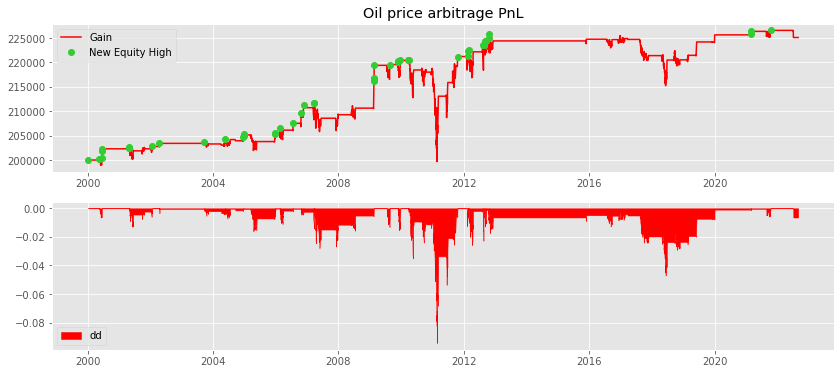

In [84]:
plt.figure(figsize = (14, 6))

plt.subplot(2, 1, 1)
plt.title("Oil price arbitrage PnL")
plt.plot(data['date'], data['pnl'], color = "red")
plt.plot(eh['date'], eh['pnl'], "o", color = "limegreen")
plt.legend(['Gain', 'New Equity High'])

plt.subplot(2, 1, 2)
plt.fill_between(data['date'], data['dd'], interpolate=False, color='red')
plt.legend(['dd'], loc = 'lower left')

plt.show()

In [85]:
mean = np.mean(data['pnl'].pct_change())*252
s = np.std(data['pnl'].pct_change())*(252**0.5)
sp = np.round(mean/s, 4)

ret = np.round((data.loc[5723, 'pnl']-200000)/200000, 4) *100
mdd = -np.round(data.loc[:, 'dd'].min(), 4) *100
rm = np.round(ret/(mdd), 4)

trade_price = []
date = []

for i in range(1, len(data)):
    if (data['pos'][i-1] == 0) & (data['pos'][i] != 0):
        trade_price.append(data['pnl'][i-1])
        date.append(data['date'][i])
    if (data['pos'][i-1] != 0) & (data['pos'][i] == 0) :
        trade_price.append(data['pnl'][i])
        date.append(data['date'][i])

trade = pd.DataFrame(date, columns = ['date'])
trade['principal'] = trade_price

#確定是否算對 
trade_point = []

for i in range(1, len(trade), 2):
    trade_point.append(round((trade['principal'][i]-trade['principal'][i-1]), 2))
#         mean_ret = round(sum(trade_ret)/len(trade_ret), 3)
#         sigma = round(np.std(trade_ret), 4)

#毛利毛損
gp = 0
gl = 0

for i in range(len(trade_point)):
    if trade_point[i] > 0 :
        gp += trade_point[i]
    elif trade_point[i] < 0:
        gl += trade_point[i]
    
pf = round((-gp/gl), 4)

#勝率和交易次數
win = 0    
loss = 0
for i in range(len(trade_point)):
    if trade_point[i] > 0 :
        win += 1
    else :
        loss +=1
trade_times = win+loss
    
if trade_times == 0 :
    win_rate = 0
elif trade_times != 0 :    
    win_rate = round(win/(trade_times), 2)


#平均持有時間
day = []

for i in range(1, len(trade), 2):
    date1 = datetime.datetime.strptime(str(trade['date'][i-1])[0:10], "%Y-%m-%d")
    date2 = datetime.datetime.strptime(str(trade['date'][i])[0:10], "%Y-%m-%d")
    num = (date2 - date1).days
    day.append(num)
    mean_day = np.round(np.mean(day), 2)

print('Return: {}%'.format(ret) +\
          "\nMDD: {}%".format(mdd) +\
          "\nReturn to MDD: {}".format(rm) +\
          "\nSharpe Ratio: {}".format(sp)+\
          "\nprofit factor: {}".format(pf) +\
          "\ntimes: {}".format(trade_times) +\
          "\nwin rate: {}".format(win_rate) +\
          "\nmean day: {}".format(mean_day))

Return: 12.540000000000001%
MDD: 9.43%
Return to MDD: 1.3298
Sharpe Ratio: 0.209
profit factor: 2.3786
times: 47
win rate: 0.68
mean day: 33.11


# 只做空

In [86]:
pos = [0]
buy_price = []

for i in range(1, len(data)):
    if pos[-1] == 0:
        if (data.loc[i, 'spread'] > data.loc[i, 'ub']) & (data.loc[i, 'fmd'] < data.loc[i, 'smd']):
            pos.append(-1)
            buy_price.append(data.loc[i+1, 'spreadd'])
        else:
            pos.append(pos[-1])
            
    elif pos[-1] < 0:
        if data.loc[i, 'spread'] < data.loc[i, 'mean']:
            pos.append(pos[-1] + 1)
#         elif (data.loc[i, 'fmd'] > data.loc[i, 'smd']):
#             pos.append(pos[-1] + 1)
        else :
            pos.append(pos[-1])
            
data['pos'] = pos
data['pos'] = data['pos'].shift()
data['pos'][0] = 0

C:\Users\User\AppData\Local\Temp\ipykernel_16236\4016635418.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pos'][0] = 0


In [87]:
date = pd.read_csv("D:/實習/統一期貨/工作/統計套利/最後結算日.csv", encoding = 'ANSI')
date['西德州最後結算日'] = pd.to_datetime(date['西德州最後結算日'])
date['布蘭特最後結算日'] = pd.to_datetime(date['布蘭特最後結算日'])

date['西德州轉倉日'] = date['西德州最後結算日'] - datetime.timedelta(5)
date['布蘭特轉倉日'] = date['布蘭特最後結算日'] - datetime.timedelta(5)

date = date[['西德州轉倉日', '布蘭特轉倉日']]

In [88]:
data['pnl'] = np.nan
fee = 100

for i in range(1, len(data)):
    if (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] == 0) & (data.loc[i, 'pos'] != 0):
        data.loc[i, 'pnl'] = -fee
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] != 0):
        #持有部位時須轉倉
        if (data.loc[i, 'date'] in np.array(date['西德州轉倉日'])):
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        elif(data.loc[i, 'date'] in np.array(date['布蘭特轉倉日'])) :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000 - fee
        else :
            data.loc[i, 'pnl'] = (data.loc[i, 'pos'] * data.loc[i, 'point'])*1000
    elif (data.loc[i-1, 'pos'] != 0) & (data.loc[i, 'pos'] == 0):
        data.loc[i, 'pnl'] = (data.loc[i-1, 'pos'] * data.loc[i, 'point'])*1000 - fee
        
data['pnl'] = (200000 + data['pnl'].cumsum())
data['high'] = data['pnl'].cummax()
data['dd'] =  (data['pnl'] - data['high'])/data['high']

eh = data.drop_duplicates(["high"])

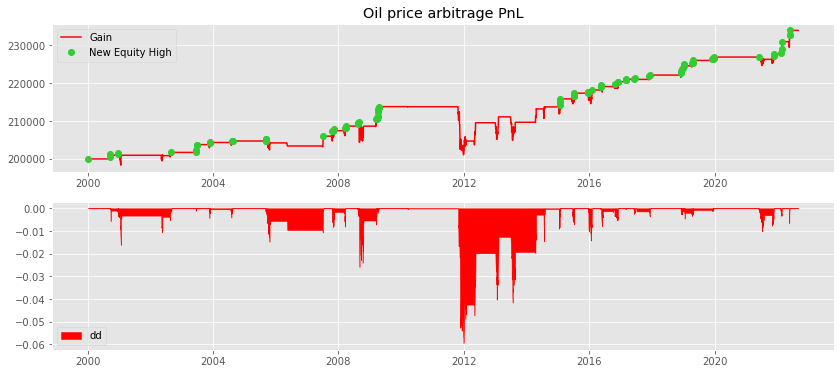

In [89]:
plt.figure(figsize = (14, 6))

plt.subplot(2, 1, 1)
plt.title("Oil price arbitrage PnL")
plt.plot(data['date'], data['pnl'], color = "red")
plt.plot(eh['date'], eh['pnl'], "o", color = "limegreen")
plt.legend(['Gain', 'New Equity High'])

plt.subplot(2, 1, 2)
plt.fill_between(data['date'], data['dd'], interpolate=False, color='red')
plt.legend(['dd'], loc = 'lower left')

plt.show()

In [90]:
mean = np.mean(data['pnl'].pct_change())*252
s = np.std(data['pnl'].pct_change())*(252**0.5)
sp = np.round(mean/s, 4)

ret = np.round((data.loc[5723, 'pnl']-200000)/200000, 4) *100
mdd = -np.round(data.loc[:, 'dd'].min(), 4) *100
rm = np.round(ret/(mdd), 4)

trade_price = []
date = []

for i in range(1, len(data)):
    if (data['pos'][i-1] == 0) & (data['pos'][i] != 0):
        trade_price.append(data['pnl'][i-1])
        date.append(data['date'][i])
    if (data['pos'][i-1] != 0) & (data['pos'][i] == 0) :
        trade_price.append(data['pnl'][i])
        date.append(data['date'][i])

trade = pd.DataFrame(date, columns = ['date'])
trade['principal'] = trade_price

#確定是否算對 
trade_point = []

for i in range(1, len(trade), 2):
    trade_point.append(round((trade['principal'][i]-trade['principal'][i-1]), 2))
#         mean_ret = round(sum(trade_ret)/len(trade_ret), 3)
#         sigma = round(np.std(trade_ret), 4)

#毛利毛損
gp = 0
gl = 0

for i in range(len(trade_point)):
    if trade_point[i] > 0 :
        gp += trade_point[i]
    elif trade_point[i] < 0:
        gl += trade_point[i]
    
pf = round((-gp/gl), 4)

#勝率和交易次數
win = 0    
loss = 0
for i in range(len(trade_point)):
    if trade_point[i] > 0 :
        win += 1
    else :
        loss +=1
trade_times = win+loss
    
if trade_times == 0 :
    win_rate = 0
elif trade_times != 0 :    
    win_rate = round(win/(trade_times), 2)


#平均持有時間
day = []

for i in range(1, len(trade), 2):
    date1 = datetime.datetime.strptime(str(trade['date'][i-1])[0:10], "%Y-%m-%d")
    date2 = datetime.datetime.strptime(str(trade['date'][i])[0:10], "%Y-%m-%d")
    num = (date2 - date1).days
    day.append(num)
    mean_day = np.round(np.mean(day), 2)

print('Return: {}%'.format(ret) +\
          "\nMDD: {}%".format(mdd) +\
          "\nReturn to MDD: {}".format(rm) +\
          "\nSharpe Ratio: {}".format(sp)+\
          "\nprofit factor: {}".format(pf) +\
          "\ntimes: {}".format(trade_times) +\
          "\nwin rate: {}".format(win_rate) +\
          "\nmean day: {}".format(mean_day))

Return: 16.96%
MDD: 5.94%
Return to MDD: 2.8552
Sharpe Ratio: 0.3726
profit factor: 3.6417
times: 40
win rate: 0.75
mean day: 24.98
